In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from gwaxion import physics

import multiprocessing
from functools import partial

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)

cmap = 'magma'

Let's obtain and plot GW amplitudes and frequencies for a range of $\alpha$'s for the following black hole:

In [2]:
bh = physics.BlackHole(mass=60, chi=0.7, msun=True)
distance = 5E6 * physics.PC_SI

alphas = np.arange(0.01, 0.25, 0.001)

To use `multiprocessing` we need top-level-defined functions, which we will used instead of the functions already defined in the `physics` module.

In [3]:
cloud = physics.BosonCloud.from_parameters(1, 1, 0, alpha=0.2, evolve_params={'y_0': 1E-8}, m_bh=bh.mass_msun, chi_bh=bh.chi) 

In [4]:
cloud.bhb_final.bh.chi

0.6880131598604433

In [5]:
def get_peak(a, lgw=2, **kwargs): 
    cloud = physics.BosonCloud.from_parameters(1, 1, 0, alpha=a, evolve_params={'y_0': 1E-8}, **kwargs) 
    return cloud.gw(lgw).h0r, cloud.gw(lgw).f

In [6]:
# collect peak values
ncpus = 8
pool = multiprocessing.Pool(ncpus)
h0r_fs = pool.map(partial(get_peak, m_bh=bh.mass_msun, chi_bh=bh.chi), alphas)

h0rs_num, fgws_num = np.array(h0r_fs).T

# h0rs are the amplitudes 1m away from the source, so rescale by actual distance
h0s_num = h0rs_num / distance

Let's get the properties at peak emission:

In [7]:
print max(zip(h0r_fs, alphas))
print h0s_num.max()

((0.008046043061908426, 190.98774574247352), 0.17799999999999988)
5.21508994340207e-26


In [8]:
bhb = physics.BlackHoleBoson.from_parameters(m_bh=bh.mass_msun, chi_bh=bh.chi, alpha=0.17799999999999988)
c = bhb.cloud(1, 1, 0)
print 'Boson mass: %.1e eV' % c.bhb_final.boson.energy_ev
print 'Final alpha: %.3f' % c.bhb_final.alpha
print 'Final BH mass: %.2f Msun' % c.bhb_final.bh.mass_msun
print 'Final BH spin: %.3f' % c.bhb_final.bh.chi
print 'Fractional BH mass lost: %.3f' % (c.mass_msun/c.bhb_initial.bh.mass_msun)

Boson mass: 4.0e-13 eV
Final alpha: 0.175
Final BH mass: 58.96 Msun
Final BH spin: 0.623
Fractional BH mass lost: 0.017


Let's compare the above results, computed by numerically solving the cloud evolution DEs, to those approximating the final mass by the initial mass for part of the calculation:

/Users/maxisi/custompy/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


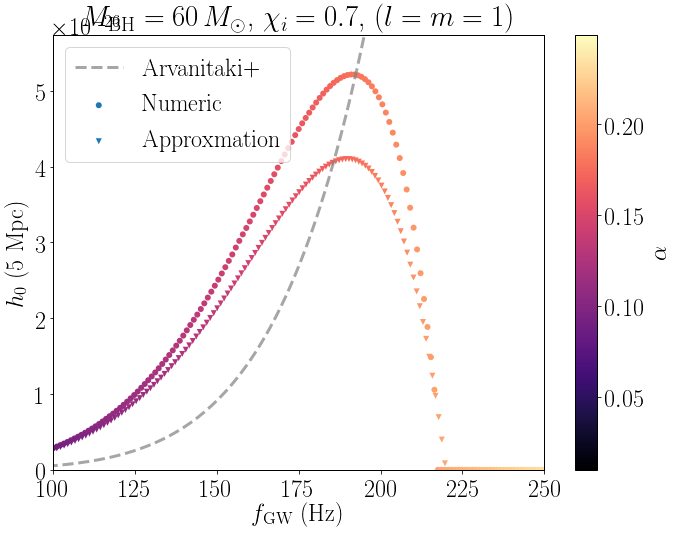

In [9]:
# Brito approximation
h0s_2, fgws_2 = physics.h0_scalar_brito(bh.mass_msun, alphas, chi_i=bh.chi, d=distance)
# Arvanitaki approximation
h0s_3, fgws_3 = physics.h0_scalar_approx(alphas, m_bh=bh.mass_msun, d=distance)

fig, ax = plt.subplots(1, figsize=(11,8))

ax.scatter(fgws_num, h0s_num, c=alphas, edgecolor='none', label='Numeric', cmap=cmap)
s = ax.scatter(fgws_2, h0s_2, c=alphas, edgecolor='none', label='Approxmation', cmap=cmap, marker='v')#, vmin=0, vmax=0.25)
ax.plot(fgws_3, h0s_3, lw=3, color='gray', ls='--', alpha=0.7, label="Arvanitaki+")

cb = plt.colorbar(s, label=r'$\alpha$')
ax.set_xlim(100, 250)
ax.set_ylim(0, max(np.nanmax(h0s_2)*1.1, np.nanmax(h0s_num)*1.1))
ax.set_xlabel(r"$f_{\rm GW}$ (Hz)")
ax.set_ylabel(r"$h_0$ (5 Mpc)")
ax.set_title(r"$M_{\rm BH}=60\,M_\odot$, $\chi_i=0.7$, $(l=m=1)$")
ax.legend(loc="best", numpoints=1)
plt.show(fig)

## Paper plot

In [19]:
reload(physics)

<module 'gwaxion.physics' from '/Users/maxisi/custompy/lib/python2.7/site-packages/gwaxion/physics.pyc'>

In [20]:
bh = physics.BlackHole(mass=60, chi=0.7, msun=True)
distance = 5E6 * physics.PC_SI

alphas = np.arange(0.01, 0.25, 0.001)

# collect peak values
ncpus = 8
pool = multiprocessing.Pool(ncpus)
h0r_fs = pool.map(partial(get_peak, m_bh=bh.mass_msun, chi_bh=bh.chi), alphas)

h0rs_num, fgws_num = np.array(h0r_fs).T

# h0rs are the amplitudes 1m away from the source, so rescale by actual distance
h0s_num = h0rs_num / distance

In [21]:
# create fit for alpha and fgw
from scipy.interpolate import interp1d
h0_interp = interp1d(fgws_num, h0s_num, bounds_error=False, fill_value='extrapolate')
alpha_interp = interp1d(fgws_num, alphas, bounds_error=False, fill_value='extrapolate')

In [22]:
# Get 1yr lne value
from scipy.optimize import brentq
def d_tinst_fixed_chi(alpha): return physics.tinst_approx(60, alpha, 0.7) - physics.YRSID_SI
alpha_1yr = brentq(d_tinst_fixed_chi, 0.0001, 0.2,)
_, f1yr = physics.get_gw(alpha_1yr, m_bh=60, chi_bh=0.7)

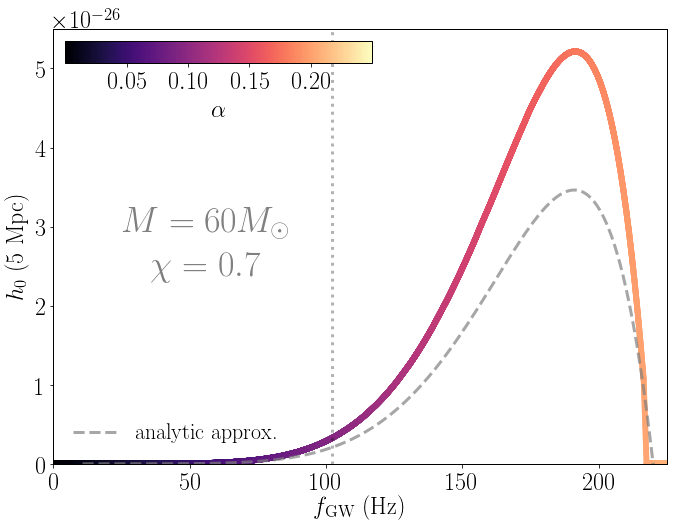

In [23]:
fig, ax = plt.subplots(1, figsize=(11,8))

fgws = np.linspace(0, 250, 10000)

# Arvanitaki approximation
h0s_arv, fgws_arv = physics.h0_scalar_approx(alphas, m_bh=bh.mass_msun, d=distance, chi=bh.chi)

ax.plot(fgws_arv, h0s_arv, lw=3, color='gray', ls='--', alpha=0.7, label="analytic approx.")
s = ax.scatter(fgws, h0_interp(fgws), c=alpha_interp(fgws), edgecolor='none', cmap=cmap, vmin=0, vmax=0.25)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="50%", height="5%", loc=2)
cb_ticks = np.linspace(0, 0.2, 5)[1:]
cb = plt.colorbar(s, label=r'$\alpha$', ticks=cb_ticks, orientation='horizontal', cax=cbaxes)

# add 1yr tinst line
ax.axvline(x=f1yr, ls=':', color='k', lw=3, alpha=0.3)

ax.set_ylim(0, 5.5E-26)
ax.set_xlim(0, 225)
ax.set_xlabel(r"$f_{\rm GW}$ (Hz)")
ax.set_ylabel(r"$h_0$ (5 Mpc)")
ax.legend(loc=3, frameon=False, fontsize=22)#loc="center", bbox_to_anchor=(0.25, 0.75))

ax.annotate(r'$M=60 M_\odot$'+'\n'+r'$\chi=0.7$', xy=(0.25, 0.5), xycoords="axes fraction", 
            ha='center', va='center', fontsize=36, color='gray')


plt.savefig('scat_h0_fgw_alpha.pdf', bbox_inches='tight')
plt.show(fig)

## Different parameters

In [14]:
# let's try this for different parameters

alphas = np.arange(0.01, 0.5, 0.001)

bh = physics.BlackHole(mass=60, chi=0.9, msun=True)

h0r_fs = pool.map(partial(get_peak, m_bh=bh.mass_msun, chi_bh=bh.chi), alphas)
h0rs_num, fgws_num = np.array(h0r_fs).T
h0s_num = h0rs_num / distance

# Brito approximation
h0s_2, fgws_2 = physics.h0_scalar_brito(bh.mass_msun, alphas, chi_i=bh.chi, d=distance)
# Arvanitaki approximation
h0s_3, fgws_3 = physics.h0_scalar_approx(alphas, m_bh=bh.mass_msun, d=distance)

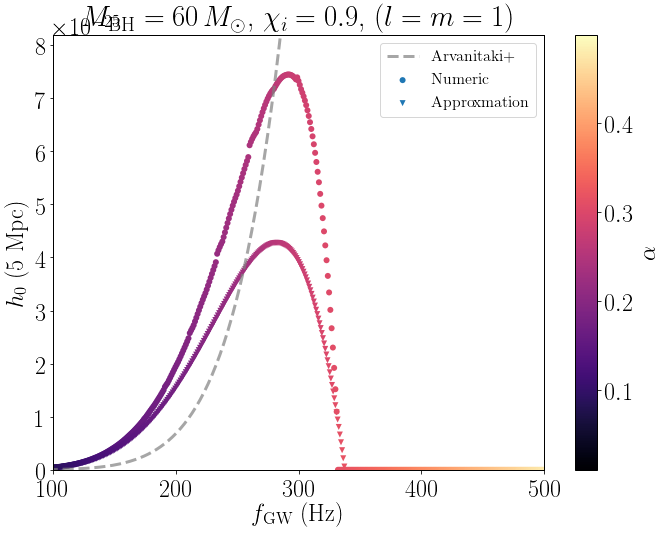

In [15]:
fig, ax = plt.subplots(1, figsize=(11,8))
ax.scatter(fgws_num, h0s_num, c=alphas, edgecolor='none', label='Numeric', cmap=cmap)
s = ax.scatter(fgws_2, h0s_2, c=alphas, edgecolor='none', label='Approxmation', cmap=cmap, marker='v')
ax.plot(fgws_3, h0s_3, lw=3, color='gray', ls='--', alpha=0.7, label="Arvanitaki+")

cb = plt.colorbar(s, label=r'$\alpha$')
ax.set_xlim(100, 500)
ax.set_ylim(0, max(np.nanmax(h0s_2)*1.1, np.nanmax(h0s_num)*1.1))
ax.set_xlabel(r"$f_{\rm GW}$ (Hz)")
ax.set_ylabel(r"$h_0$ (5 Mpc)")
ax.set_title(r"$M_{\rm BH}=60\,M_\odot$, $\chi_i=0.9$, $(l=m=1)$")
ax.legend(loc="upper right", numpoints=1, fontsize=16)
plt.show(fig)

In [16]:
max(h0r_fs)

(0.11487298084682186, 291.50094702513223)

In [17]:
max(h0rs_num)/distance

7.445559544902391e-25